In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm

from fastai import *
from fastai.vision import *
import matplotlib.pyplot as plt
import os

from torch.autograd import Variable

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=64)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

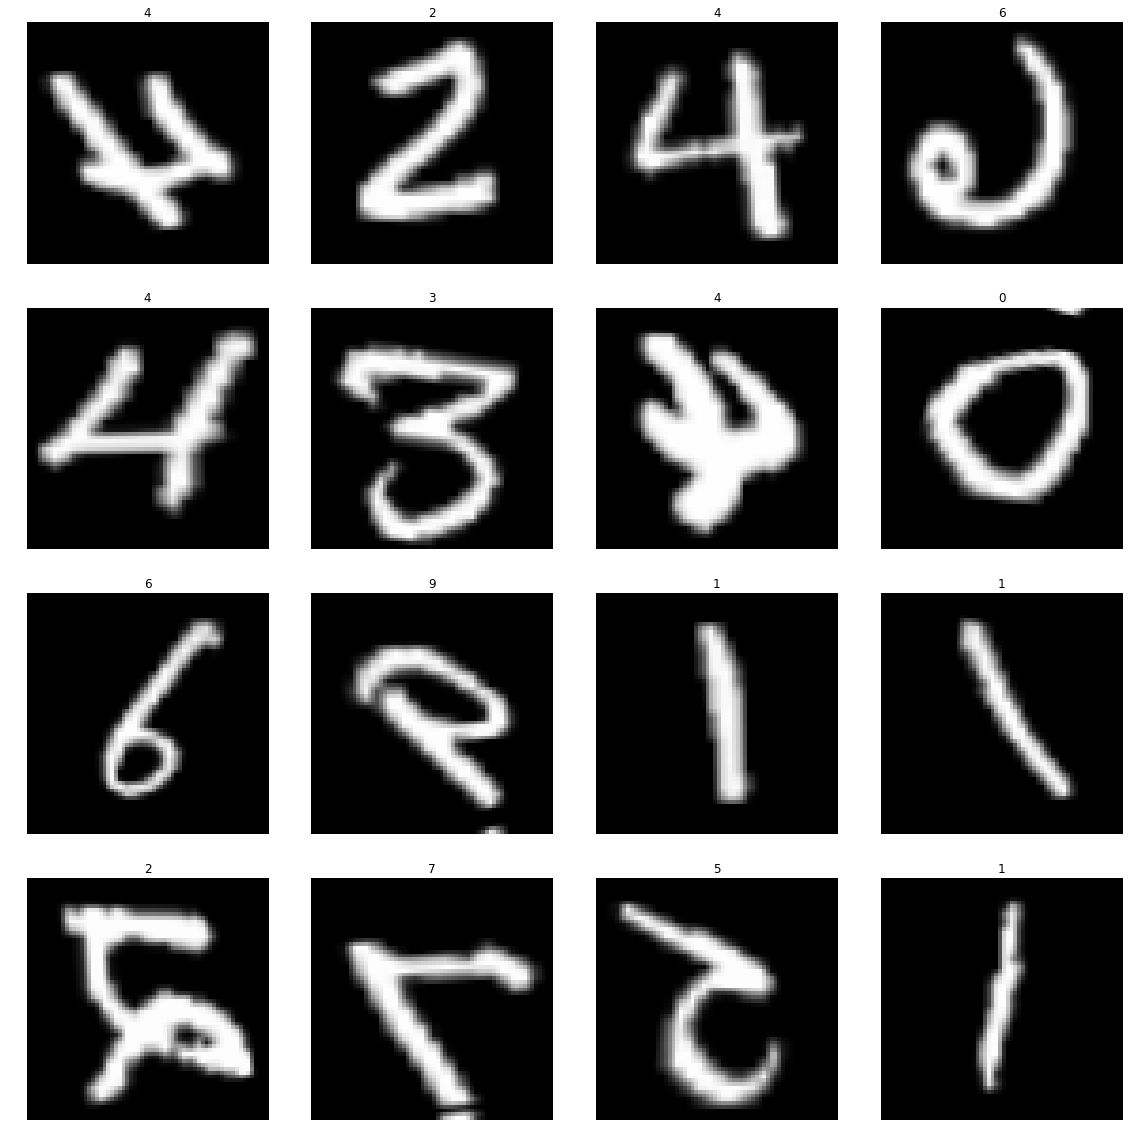

In [4]:
data.show_batch(4)

In [5]:
data.c

10

# IT WORKS!!!

In [35]:
from torchviz import make_dot

In [68]:
image_channels = 3
image_size = 64
start_channels = 64
finish_channels = 128
stepper = 16
num_class = 10
current_channel = start_channels
required_accuracy = 80
per_cycle_epoch = 10

In [69]:
class Model(nn.Module):
    def __init__(self, model):
        super(Model, self).__init__()
        self.p1 = nn.Sequential(*model)

    #         self.classif = nn.Conv2d(32, 10, 1, 1)

    def forward(self, x):
        x = self.p1(x)
        #         x = self.classif(x)
        x = torch.flatten(x, 1)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):

                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [70]:
model = [
    conv_layer(image_channels, start_channels),
    conv_layer(current_channel, num_class),
]

In [71]:
x = torch.zeros(1, 3, 64, 64, dtype=torch.float, requires_grad=False)

In [72]:
# out = resnet(x)
# make_dot(out)

In [73]:
for a in range(start_channels, finish_channels + stepper, stepper):

    model.insert(-1, conv_layer(a, current_channel + stepper))
    model.insert(-1, res_block(current_channel + stepper))
    model.insert(-1, nn.MaxPool2d(2))
    current_channel += stepper
    model[-1] = conv_layer(current_channel, num_class)
    out = Model(model)(x)
    make_dot(out, params=dict(Model(model).named_parameters())).render(f"attached{a}")
    #     print("\nME\n")
    #     print(model)
    print(f"[INFO] Number of channels now = {current_channel}")
    learn = None
    gc.collect()
    m = Model(model)
    m._initialize_weights()
    learn = Learner(data, m.cuda(), metrics=[accuracy], opt_func=AdamW).to_fp16()
    #     print(learn.model)
    learn.unfreeze()
    learn.fit_one_cycle(per_cycle_epoch, wd=1e-3)
    current_val = learn.validate()[-1].item()*100
    print(current_val, model[-1])
    if current_val >= required_accuracy - 5:
        break


#     break

[INFO] Number of channels now = 80


epoch,train_loss,valid_loss,accuracy,time
0,3.320754,3.284899,0.111786,00:46
1,3.161556,3.179589,0.098786,00:46
2,3.146820,3.215757,0.111857,00:46
3,3.131737,3.176144,0.098786,00:46
4,3.113966,3.174582,0.100071,00:46
5,3.141937,3.201612,0.098929,00:46
6,3.113652,3.177892,0.111857,00:48
7,3.122230,3.170890,0.111786,00:47
8,3.120715,3.172497,0.111786,00:47
9,3.112245,3.169581,0.111786,00:46


11.178571730852127 Sequential(
  (0): Conv2d(80, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same

In [512]:
learn.model

Model(
  (p1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): SequentialEx(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): Sequential(
          (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(80, eps=1e-05

# PLAYGROUND

# Architecture test

In [31]:
conv_layer(1, 5)

Sequential(
  (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Base

In [80]:
model = [conv_layer(3, 64), conv_layer(512, 10)]
current = 64
for stepper in range(64 + 16, 512 + 16, 16):
    model.insert(1, conv_layer(current, stepper))
    current = stepper
    model[-1] = conv_layer(current, 10)
    now_model = nn.Sequential(*model).cuda()
    print(now_model)
    learn = None
    gc.collect()
    learn = Learner(
        data, now_model, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
    )
    learn.unfreeze()
    learn.lr_find()
    learn.recorder.plot()

    break

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(80, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: Expected input batch_size (40960) to match target batch_size (64).

# Test

In [82]:
learn = None
gc.collect()

753

In [91]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [92]:
def flatten(x):
    return x.view(x.shape[0], -1)

In [119]:
model = [conv_layer(3, 64), conv_layer(64, 10)]

In [130]:
m = nn.Sequential(*model)
m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [158]:
test = torch.randn(1, 3, 64, 64).cuda()
test = m(test)
test = test.view(test.shape[0], -1)
test.shape

torch.Size([1, 40960])

In [250]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.p1 = nn.ModuleList([conv_layer(3, 64), conv_layer(64, 128)])
        self.classif = nn.Conv2d(128, 10, 1, 1)

    def forward(self, x):
        x = self.p1(x)
        x = self.classif(x)
        return x

In [252]:
m = Model()

In [255]:
m.p1 = nn.ModuleList([conv_layer(3, 64), conv_layer(64, 128), conv_layer(128, 256)])
m.classif = nn.Conv2d(256, 10, 1, 1)

# Defining

In [185]:
def finisher(chan, classes):
    return nn.Conv2d(chan, classes, 3, 1, 1)

In [334]:
image_channels = 3
image_size = 64
start_channels = 64
finish_channels = 128
stepper = 16
num_class = 10
current_channel = start_channels
test = torch.randn(1, image_channels, image_size, image_size).cuda()

In [335]:
model = [conv_layer(image_channels, start_channels)]

In [336]:
for stepper in range(start_channels + stepper, finish_channels + stepper, stepper):
    model.append(conv_layer(current_channel, current_channel + stepper))
    current_channel += stepper

# model.append(conv_layer(current_channel, 32))
model.append(nn.Conv2d(current_channel, 10, 1, 1))

In [337]:
model

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): ReLU(inplace=True)
   (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Conv2d(64, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): ReLU(inplace=True)
   (2): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Conv2d(144, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): ReLU(inplace=True)
   (2): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Conv2d(240, 352, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): ReLU(inplace=True)
   (2): BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Sequential(
   (0): Conv2d(352, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): ReLU(inplace

In [328]:
class Model(nn.Module):
    def __init__(self, model):
        super(Model, self).__init__()
        self.p1 = nn.Sequential(*model)
        self.classif = nn.Conv2d(32, 10, 1, 1)

    def forward(self, x):
        x = self.p1(x)
        x = self.classif(x)
        x = torch.flatten(x, 1)
        return x

In [329]:
m = Model(model)
m

Model(
  (p1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(144, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(240, 352, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequentia

In [330]:
learn = None
gc.collect()

640

In [331]:
learn = Learner(data, m.cuda(), metrics=[accuracy], opt_func=AdamW)

In [332]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
torch.Size([64, 40960])
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [333]:
import tqdm

In [148]:
learn = Learner(data, Model().cuda(), metrics=[accuracy], opt_func=AdamW)

In [149]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


Traceback (most recent call last):
  File "/home/subhaditya/anaconda3/lib/python3.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/home/subhaditya/anaconda3/lib/python3.7/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/subhaditya/anaconda3/lib/python3.7/multiprocessing/util.py", line 110, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/subhaditya/anaconda3/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/subhaditya/anaconda3/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-8m_mogsq'


torch.Size([64, 64, 64, 64])
64


RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for classif.weight: copying a param with shape torch.Size([10, 1]) from checkpoint, the shape in current model is torch.Size([10, 64]).

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-3), wd=1e-3)

In [ ]:
learn.show_results()